# Metrics
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load results

In [7]:
# mmm: multimodel mean (is at the last index)
multimodel_ensemble_bias_mmm_tas = xr.open_dataarray(
    'results/tas_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)
multimodel_ensemble_bias_mmm_snc = xr.open_dataarray(
    'results/snc_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)
multimodel_ensemble_bias_mmm_pr = xr.open_dataarray(
    'results/pr_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)

## Sorted by resolution

### tas

In [22]:
# Data shape (season, model, metric)

list_data_tas = [None]*len(seasons)

# Keep the multimodel mean separate ([:-1])
model_sorted = multimodel_ensemble_bias_mmm_tas.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).model.values
model_sorted = np.append(model_sorted, multimodel_ensemble_bias_mmm_tas.model[-1].values)

resolution = multimodel_ensemble_bias_mmm_tas.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).resolution
resolution = np.append(resolution, multimodel_ensemble_bias_mmm_tas.resolution[-1].values)

model_label = [model + ' ('+res+')' for model, res in zip(model_sorted, resolution)]

for i, season in enumerate(seasons):
    data = np.ndarray(shape=(multimodel_ensemble_bias_mmm_tas.model.size, 2))

    data[:,0] = multimodel_ensemble_bias_mmm_tas.sel(season=season).reindex(model=model_sorted).rmse
    data[:,1] = multimodel_ensemble_bias_mmm_tas.sel(season=season).reindex(model=model_sorted).mean_bias

    list_data_tas[i] = pd.DataFrame(
        data, columns=pd.Index(['RMSE', 'Mean Bias'], name='Metric'),
        index=pd.Index(model_label, name='Model')
    )

# data

### snc

In [23]:
# Data shape (season, model, metric)

list_data_snc = [None]*len(seasons)

# Keep the multimodel mean separate ([:-1])
model_sorted = multimodel_ensemble_bias_mmm_snc.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).model.values
model_sorted = np.append(model_sorted, multimodel_ensemble_bias_mmm_snc.model[-1].values)

resolution = multimodel_ensemble_bias_mmm_snc.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).resolution
resolution = np.append(resolution, multimodel_ensemble_bias_mmm_snc.resolution[-1].values)

model_label = [model + ' ('+res+')' for model, res in zip(model_sorted, resolution)]

for i, season in enumerate(seasons):
    data = np.ndarray(shape=(multimodel_ensemble_bias_mmm_snc.model.size, 2))

    data[:,0] = multimodel_ensemble_bias_mmm_snc.sel(season=season).reindex(model=model_sorted).rmse
    data[:,1] = multimodel_ensemble_bias_mmm_snc.sel(season=season).reindex(model=model_sorted).mean_bias

    list_data_snc[i] = pd.DataFrame(
        data, columns=pd.Index(['RMSE', 'Mean Bias'], name='Metric'),
        index=pd.Index(model_label, name='Model')
    )

# data

### pr

In [24]:
# Data shape (season, model, metric)

list_data_pr = [None]*len(seasons)

# Keep the multimodel mean separate ([:-1])
model_sorted = multimodel_ensemble_bias_mmm_pr.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).model.values
model_sorted = np.append(model_sorted, multimodel_ensemble_bias_mmm_pr.model[-1].values)

resolution = multimodel_ensemble_bias_mmm_pr.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).resolution
resolution = np.append(resolution, multimodel_ensemble_bias_mmm_pr.resolution[-1].values)

model_label = [model + ' ('+res+')' for model, res in zip(model_sorted, resolution)]

for i, season in enumerate(seasons):
    data = np.ndarray(shape=(multimodel_ensemble_bias_mmm_pr.model.size, 2))

    data[:,0] = multimodel_ensemble_bias_mmm_pr.sel(season=season).reindex(model=model_sorted).rmse
    data[:,1] = multimodel_ensemble_bias_mmm_pr.sel(season=season).reindex(model=model_sorted).mean_bias

    list_data_pr[i] = pd.DataFrame(
        data, columns=pd.Index(['RMSE', 'Mean Bias'], name='Metric'),
        index=pd.Index(model_label, name='Model')
    )

# data

## Plot

In [27]:
list_data_vars = [
    list_data_tas, 
    list_data_snc, 
    list_data_pr
]

list_vars = ['tas', 'snc', 'pr']
ylabel_list = ['Temperature [°C]', 'Snow Cover Extent [%]', 'Total Precipitation [mm/day]']

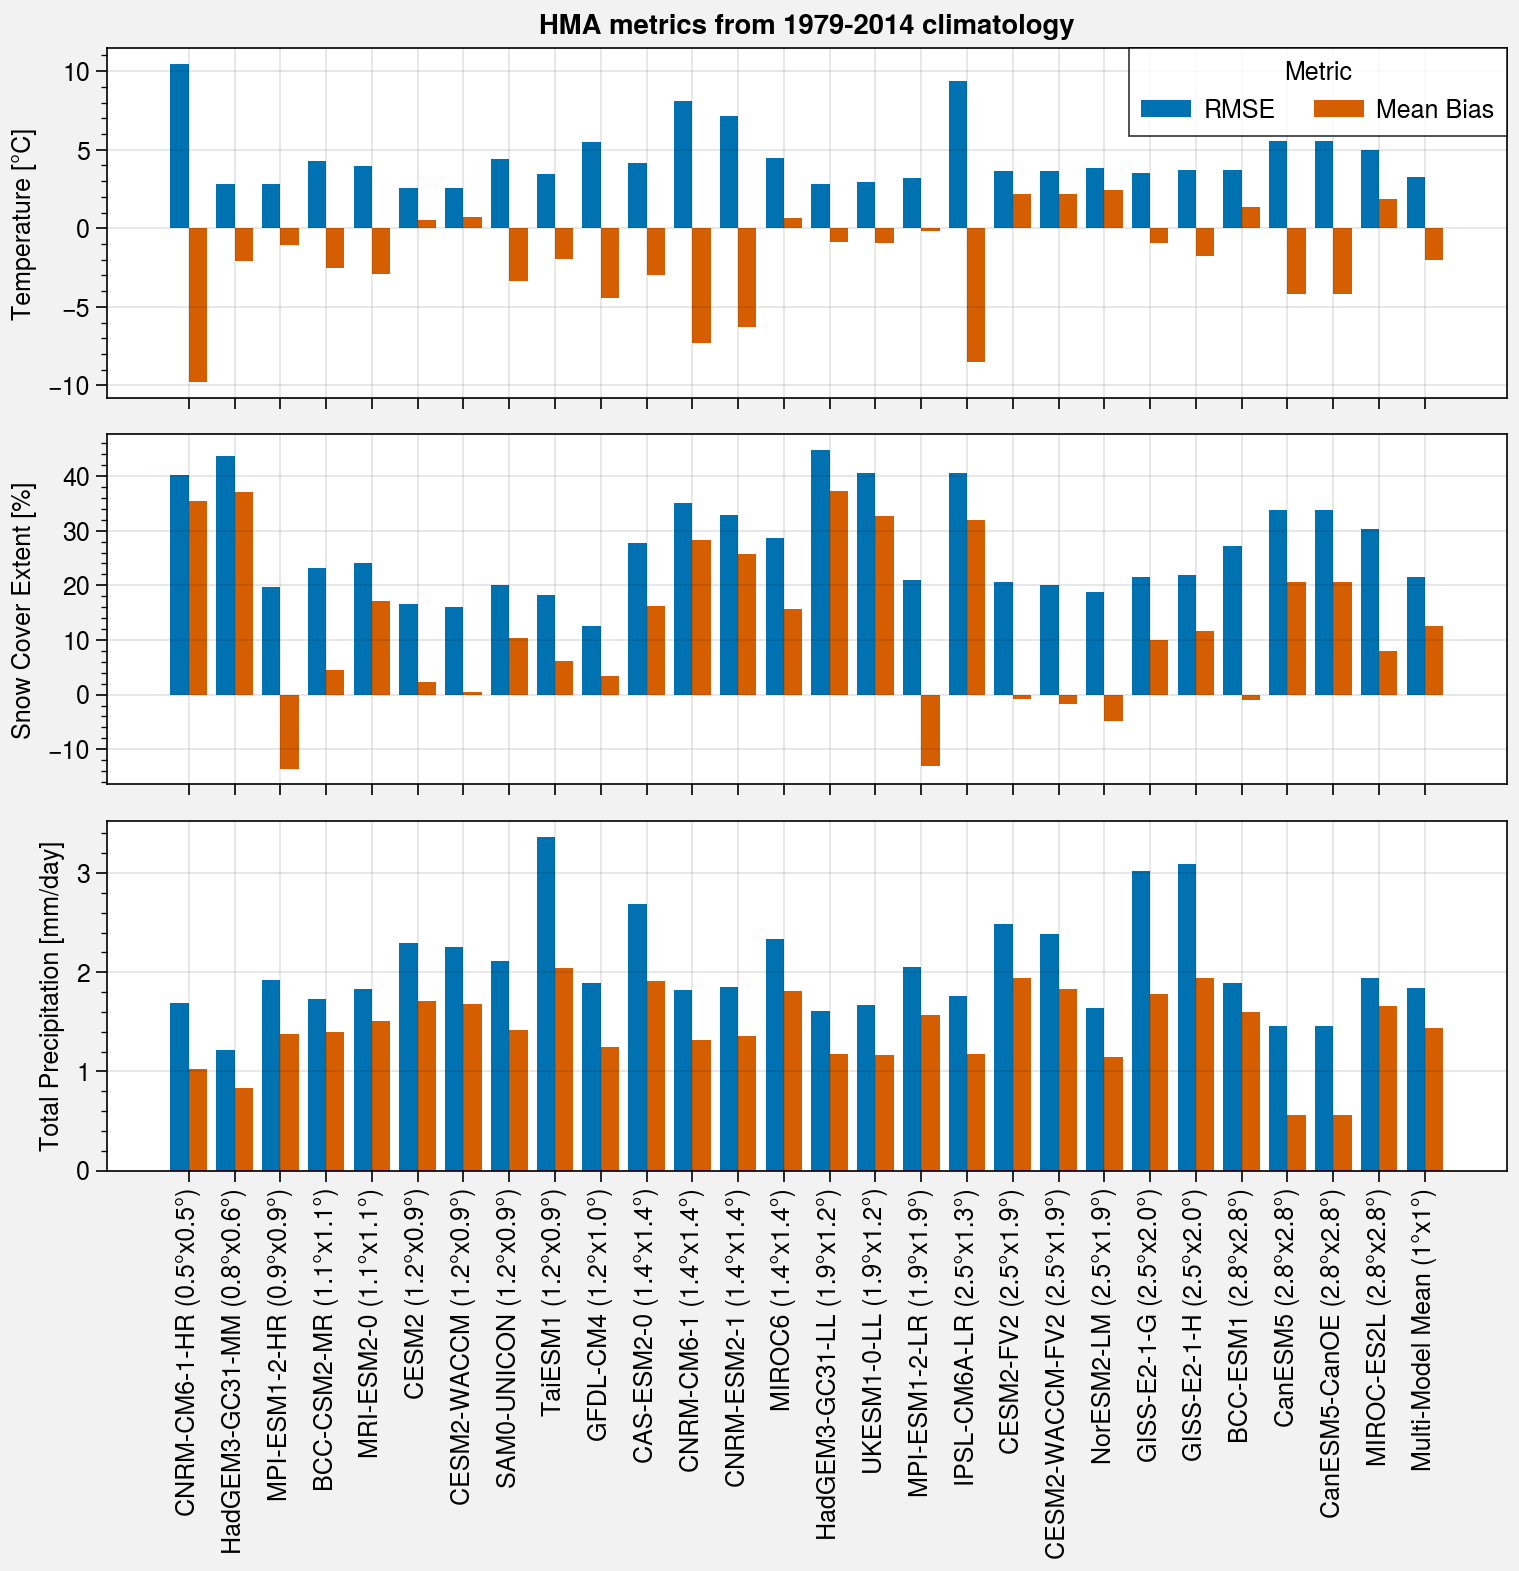

In [31]:
f, axs = plot.subplots(nrows=3, aspect=4, axwidth=7, sharey=0)

# ylim_list = 

# lim = 13.5
cycle = '538'
for i, var in enumerate(list_vars):
    if i == 0:
        # list_data_vars[i][0] -> i: variable, 0: annual
        axs[i].bar(list_data_vars[i][0], legend='ur', linewidth=0)
    else:
        axs[i].bar(list_data_vars[i][0], linewidth=0)

    axs[i].format(
        ylabel = ylabel_list[i], xlabel='', xrotation=90,
        suptitle = 'HMA metrics from '+period.start+'-'+period.stop+' climatology'
    )
    
filename = 'metrics_by_res_all_'+season+'_'+period.start+'-'+period.stop
f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')